In [ ]:
!pip install langchain-groq
!pip install --upgrade -U langchain-core langchain-groq langchain_groq langchain

In [ ]:
from langchain_groq import ChatGroq

from dotenv import load_dotenv
import os
load_dotenv()
groq_api_key = os.getenv("groq_api_key")
llm = ChatGroq(model_name="llama-3.1-8b-instant", api_key=groq_api_key)

Importing all the Libraries

In [ ]:
from pydantic import BaseModel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
from langgraph.graph import StateGraph, START, END

Defining the State Object

In [ ]:
class State(BaseModel):
    input: str
    route: str | None = None
    output: str | None = None

Defining the State Graph

In [ ]:
graph = StateGraph(State)

In [ ]:
from langchain_core.output_parsers import StrOutputParser

system_prompt = """
You are a helpful assistant that can answer questions about Mental Health.
"""

user_question = "What are some effective strategies for managing anxiety and stress in daily life?"

human_prompt = f"""
{user_question}
"""

from langchain_core.prompts import ChatPromptTemplate , SystemMessagePromptTemplate , HumanMessagePromptTemplate

system_message_prompt = SystemMessagePromptTemplate.from_template(system_prompt)

human_message_prompt = HumanMessagePromptTemplate.from_template(human_prompt)

prompt = ChatPromptTemplate.from_messages([system_message_prompt , human_message_prompt])

chain = prompt | llm | StrOutputParser()

chain.invoke({"user_question":user_question})

"Managing anxiety and stress is crucial for maintaining overall well-being. Here are some effective strategies for managing anxiety and stress in daily life:\n\n1. **Deep Breathing Exercises**: Practice deep, slow breaths to calm your mind and body. You can inhale for a count of four, hold for a count of seven, and exhale for a count of eight.\n2. **Mindfulness Meditation**: Focus on the present moment, without judgment. You can use apps like Headspace or Calm to guide you.\n3. **Physical Activity**: Regular exercise, such as walking, running, or yoga, can help reduce anxiety and stress.\n4. **Grounding Techniques**: Use your senses to ground yourself in the present moment. For example, notice the sensation of your feet on the ground, the sounds around you, or the sensation of the air on your skin.\n5. **Journaling**: Write down your thoughts and feelings to process and release them.\n6. **Connect with Nature**: Spend time outdoors, whether it's walking, hiking, or simply sitting in a 

In [ ]:
def router_agent(state: State) -> State:
    system_prompt = (
        "You are a helpful assistant. Based on the user's input, "
        "decide whether to route the request to a TECH agent or a CASUAL agent. "
        "If the input is technical in nature, respond with 'TECH', otherwise respond with 'CASUAL'."
    )

    user_prompt = state.input

    # Create chat prompt
    system_template = SystemMessagePromptTemplate.from_template("{system_prompt}")
    user_template = HumanMessagePromptTemplate.from_template("{user_prompt}")
    final_template = ChatPromptTemplate.from_messages([system_template, user_template])

    # Call LLM
    chain = final_template | llm | StrOutputParser()
    result = chain.invoke({"system_prompt": system_prompt, "user_prompt": user_prompt})

    route = "tech_agent" if "TECH" in result.upper() else "casual_agent"
    return State(input=state.input, route=route, output=None)

# ----- Conditional Routing -----
def route_next(state: State):
    return state.route  # Must return the node name as string

In [ ]:
def tech_agent(state: State) -> State:
    return State(input=state.input, route=state.route, output="Output from TECH agent")

In [ ]:
def casual_agent(state: State) -> State:
    return State(input=state.input, route=state.route, output="Output from CASUAL agent")

In [ ]:
def route_next(state: State):
    return state.route  # Must return the node name as string

In [ ]:
graph.add_node("router_agent", router_agent)
graph.add_node("tech_agent", tech_agent)
graph.add_node("casual_agent", casual_agent)

# Add conditional edge from router_agent
graph.add_conditional_edges(
    "router_agent",
    route_next,
    {
        "tech_agent": "tech_agent",
        "casual_agent": "casual_agent"
    }
)

# Add end edges
graph.add_edge("tech_agent", END)
graph.add_edge("casual_agent", END)

# Set entry point
graph.set_entry_point("router_agent")

In [ ]:
multi_agent_graph = graph.compile()

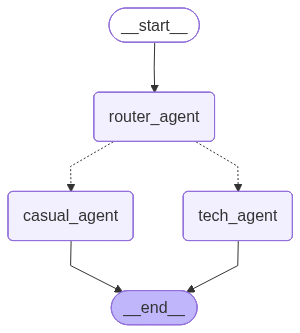

In [ ]:
multi_agent_graph

In [ ]:
def chat(user_input: str) -> State:
    initial_state = State(input=user_input)
    result = multi_agent_graph.invoke(initial_state)
    return result

prompt_here = "Explain how to use Python decorators."
response_state = chat(prompt_here)
print(response_state)

{'input': 'Explain how to use Python decorators.', 'route': 'tech_agent', 'output': 'Output from TECH agent'}
